说明：  
&ensp;&ensp;本文件使用 Data clean 2 得到的数据集。里面的bank_detail_stats, browse_history_stats,bill_detail_stats 都有不同程度的缺失。当然，目标变量 target的未知数据集部分是缺失的。

<font face="微软雅黑" size=5> Contents： </font>  
1. XGBOOST特征重要性  
&ensp;&ensp;&ensp;&ensp;1.1 数据准备  
&ensp;&ensp;&ensp;&ensp;1.2 XGBOOST特征重要性  
2. 数据整理  
&ensp;&ensp;&ensp;&ensp;2.1 特征空值率检查  
&ensp;&ensp;&ensp;&ensp;2.2 算法填充空值  
&ensp;&ensp;&ensp;&ensp;2.3 标准化  
&ensp;&ensp;&ensp;&ensp;2.4 计算相关系数矩阵  
&ensp;&ensp;&ensp;&ensp;2.5 特征值分解/奇异值分解  
3. Logistic Regression  
&ensp;&ensp;&ensp;&ensp;3.1 数据准备  
&ensp;&ensp;&ensp;&ensp;3.2 GridSearchCV交叉验证粗取最佳超参数  
&ensp;&ensp;&ensp;&ensp;3.3 对验证集进行预测并求得AUC---法1  
&ensp;&ensp;&ensp;&ensp;3.4 对验证集进行预测并求得AUC---法2  
&ensp;&ensp;&ensp;&ensp;3.5 查看并分析详细信息  
&ensp;&ensp;&ensp;&ensp;3.6 hyperopt求取最佳超参数  
&ensp;&ensp;&ensp;&ensp;3.7 交叉验证  
&ensp;&ensp;&ensp;&ensp;3.8 训练最终LR模型并预测未知样本集  
4. 提交结果  


In [1]:
import Custom_Functions as CF    # 此文档记录了部分自定义函数。
import numpy as np
import pandas as pd
import time
from scipy import special
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials,rand
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import time
from sklearn.externals import joblib
import pickle
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# 1. XGBOOST 特征重要性

## 1.1 数据准备

In [2]:
# 读取数据集 data1，记为 data

data = pd.read_csv(r'F:\RiskPre2\Data clean 2\data1.csv').set_index("userID")

In [3]:
data.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.897688,0.863700,0.847896,0.944211,0.000000,0.0,3.0,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.899329,0.898521,0.897713,0.963119,0.481559,0.0,3.0,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.664418,5914855887,0.0


In [4]:
# 从数据集 data中提取出训练集和未知样本集
# 训练集 data_tr，(55381, 425)。未知样本集 data_te，(13899, 425)

userIDtrain = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtrain.csv').values.flatten()
userIDtest = pd.read_csv(r'F:\RiskPre2\Data clean 1\userIDtest.csv').values.flatten()
data_tr = data.loc[userIDtrain,:]
print("shape of data_tr is:",data_tr.shape )
data_te = data.loc[userIDtest,:]
print("shape of data_te is:",data_te.shape )

shape of data_tr is: (55381, 719)
shape of data_te is: (13899, 719)


In [5]:
data_tr.head()

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.897688,0.863700,0.847896,0.944211,0.000000,0.0,3.0,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0
4,0,1,0,0,0,0,0,1,0,0,...,0.899329,0.898521,0.897713,0.963119,0.481559,0.0,3.0,59.110850,5914855887,1.0
5,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,20.664418,5914855887,0.0


In [6]:
# 对训练集 data_tr 进行目标变量分离，分成 字段部分 X_tr和 目标变量部分 y_tr。
# 对未知样本集 data_te 进行目标变量分离，分成 字段部分 X_te和 目标变量部分 y_te。


X_tr = data_tr.drop(["target"],axis=1)
y_tr = data_tr.loc[:,"target"]
X_te = data_te.drop(["target"],axis=1)
y_te = data_te.loc[:,"target"]
print("shape of X_tr is:",X_tr.shape)
print("shape of y_tr is:",y_tr.shape)
print("shape of X_te is:",X_te.shape)
print("shape of y_te is:",y_te.shape)

shape of X_tr is: (55381, 718)
shape of y_tr is: (55381,)
shape of X_te is: (13899, 718)
shape of y_te is: (13899,)


In [7]:
X_tr.head(3)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887
2,0,1,0,0,0,1,0,0,0,0,...,0.487417,0.897688,0.8637,0.847896,0.944211,0.0,0.0,3.0,61.523250,5914855887
3,0,1,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887


In [8]:
y_tr.head(2)

userID
1    0.0
2    0.0
Name: target, dtype: float64

## 1.2 XGBOOST 特征重要性

1. 将训练集二八分划分成训练集和验证集（shuffle+stratify），训练集和验证集同时给到XGB，训练出XGB模型。通过feature_importance得到所有特征的重要性，并用表格法和图示法展示。
2. 用此模型小试一下，对验证集进行概率预测（关注排序而非真实的预测概率绝对值）。自定义 ks_statistic函数计算K-S统计量值为0.45， ks_curve函数画K-S图线。

In [9]:
# 使用 train_test_split 将 X_tr, y_tr 二八划分成训练集 X_tr_train,y_tr_train 和 验证集 X_tr_test, y_tr_test。
# 可见，训练集 44304 个用户，验证集 11077 个用户。
# train_test_split 默认 shuffle数据，所以不必担心。还可以设置 stratify 分层抽样。


X_tr_train, X_tr_test, y_tr_train, y_tr_test = train_test_split(X_tr, y_tr, test_size = 0.2, shuffle=True, stratify=y_tr, random_state = 0)
print("shape of X_tr_train is:",X_tr_train.shape)
print("shape of y_tr_train is:",y_tr_train.shape)
print("shape of X_tr_test is:",X_tr_test.shape)
print("shape of y_tr_test is:",y_tr_test.shape)
scale_pos_weight_value=len(y_tr_train[y_tr_train==0])/len(y_tr_train[y_tr_train==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_train is:",scale_pos_weight_value)
scale_pos_weight_value1=len(y_tr_test[y_tr_test==0])/len(y_tr_test[y_tr_test==1]) # XGB默认label==0是反类，label==1是正类。
print("negative number/positive number in y_tr_test is:",scale_pos_weight_value1)
# 可见，二八分得的训练集和验证集里的 正负样本比例基本相同，即实现了 stratify.

shape of X_tr_train is: (44304, 718)
shape of y_tr_train is: (44304,)
shape of X_tr_test is: (11077, 718)
shape of y_tr_test is: (11077,)
negative number/positive number in y_tr_train is: 6.7441006816990035
negative number/positive number in y_tr_test is: 6.746153846153846


In [10]:
X_tr_train.head(3)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
950,0,1,0,0,0,1,0,0,0,0,...,0.0,0.897324,0.895973,0.894623,0.967102,0.483551,0.0,2.0,42.631748,5915633487
52463,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,60.501599,5931617487
26796,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,39.814708,5928247887


In [11]:
# 使用 X_tr_train,y_tr_train作为训练集 ，X_tr_test, y_tr_test作为验证集。训练一个 XGB模型。


modelXGB1 = XGBClassifier(
    max_depth=6,                        # 树的最大深度
    # learning_rate=0.1,（默认）         # 提升树的学习率                     
    n_estimators=1000,                  # 树的个数--1000棵树建立xgboost
    # silent = True,（默认）             # 此为默认设置，打印running boosting时的message。
    objective='binary:logistic',        # 指定损失函数
    # nthread = -1,（默认）              # 此为默认设置，并行线程数。
    # gamma=0,（默认）                   # 设置节点划分要达到的loss减小量
    # min_child_weight = 1,（默认）      # 叶子节点最小实例数据权重和
    # max_delta_step = 0,（默认）        # 此为默认设置，每棵树权重改变的最大步长。
    # subsample=1,（默认）               # 训练每棵树时实例数据随机采样的比例
    # colsample_btree=1,（默认）         # 训练每棵树时特征采样的比例
    # colsample_bylevel = 1,（默认）     # 此为默认设置，树的每一级的每一次分裂时，对特征的采样比例。
    # reg_alpha = 0,（默认）             # 此为默认设置，L1正则项系数。
    # reg_lambda = 1,（默认）            # 此为默认设置，L2正则项系数。
    scale_pos_weight = scale_pos_weight_value,   # 设置正类别样本的权重。解决正反样本个数不平衡的问题。
    # base_score = 0.5,（默认）          # 此为默认设置，
    seed = 1,                           # 随机数，因为涉及到随机采样等随机过程。
    missing = np.nan                    # XGB是能处理带缺失值的数据的模型，所以需要指出数据集中用什么代表缺失值。不过我的数据无缺失。      
    )

timestart = time.time()
modelXGB1.fit(X_tr_train,y_tr_train,eval_set = [(X_tr_train,y_tr_train),(X_tr_test, y_tr_test)],eval_metric =["logloss","auc"] ,early_stopping_rounds = 10,verbose = True)
print("Time: {:.2f} seconds".format(time.time() - timestart))

[0]	validation_0-logloss:0.667642	validation_0-auc:0.788938	validation_1-logloss:0.669106	validation_1-auc:0.758766
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.646756	validation_0-auc:0.797543	validation_1-logloss:0.649834	validation_1-auc:0.763983
[2]	validation_0-logloss:0.629631	validation_0-auc:0.802977	validation_1-logloss:0.634065	validation_1-auc:0.769324
[3]	validation_0-logloss:0.614322	validation_0-auc:0.810713	validation_1-logloss:0.620374	validation_1-auc:0.775282
[4]	validation_0-logloss:0.601679	validation_0-auc:0.815408	validation_1-logloss:0.608992	validation_1-auc:0.779478
[5]	validation_0-logloss:0.590398	validation_0-auc:0.819028	validation_1-logloss:0.599392	validation_1-auc:0.781009
[6]	validation_0-logloss:0.580463	validation_0-auc:0.823228	validation_1-logloss:0.590685	validation_1-auc:0.783552
[7]	validation_0-logloss:0.5716

Stopping. Best iteration:
[58]	validation_0-logloss:0.435287	validation_0-auc:0.904465	validation_1-logloss:0.492369	validation_1-auc:0.799453

Time: 523.25 seconds


In [12]:
modelXGB1.best_iteration

58

In [13]:
modelXGB1.best_ntree_limit

59

In [14]:
modelXGB1.best_score

0.799453

&ensp;&ensp;赛题选择的这个K-S统计量，只与被预测样本的排序有关，而与真正的逾期概率值本身的绝对大小无关。get到这点很重要。所以，在训练模型的时候，我们关注的就仅仅是预测的排序，而非预测为违约的实际概率值。这种情况，用AUC作为评价函数就比较好，此指标只与排序有关，与预测的概率值的绝对大小无关。而且，这种情况下，若总体样本不平衡，则可以使用 scale_pos_weight或class_weight这样的参数调整类别不平衡。（调整这样的参数会影响到 预测的概率值的绝对大小，但对提高预测排序的准确性有帮助）。  
&ensp;&ensp;Data clean 1 中，用XGBOOST计算特征重要性时，得到的结果是：  
Stopping. Best iteration:  
[62]	validation_0-logloss:0.43844	validation_0-auc:0.905732	validation_1-logloss:0.500588	validation_1-auc:0.787411    
&ensp;&ensp;此处Data clean 2 中，用XGBOOST计算特征重要性时，得到的结果是：   
Stopping. Best iteration:  
[58]	validation_0-logloss:0.435287	validation_0-auc:0.904465	validation_1-logloss:0.492369	validation_1-auc:0.799453  
&ensp;&ensp;可见，虽然 本文中对训练集的auc不如Data clean 1高，但对验证集的auc却比Data clean 1高。

In [15]:
# 以表格的形式查看特征重要性

featurenames = X_tr_train.columns
FeatureImportance = pd.DataFrame(data = modelXGB1.feature_importances_, index = featurenames, columns = ['feature importance'])
FeatureImportance = FeatureImportance.sort_values(by = ['feature importance'], ascending=False)

In [16]:
FeatureImportance

,feature importance
loan_time,0.024588
gender_OHE_0,0.012439
browse_ALLbn_8_count,0.009257
browse_ALLbn_10_count,0.008100
browse_BLbn_10_count,0.007810
browse_ALLbn_10_sum/ALL_sum,0.007521
browse_ALLbn_4_sum,0.006942
browse_BLbn_6_sum,0.006653
bill_ALL_last_bill_balance_std,0.006653
browse_ALLbn_1_sum/ALL_sum,0.006364


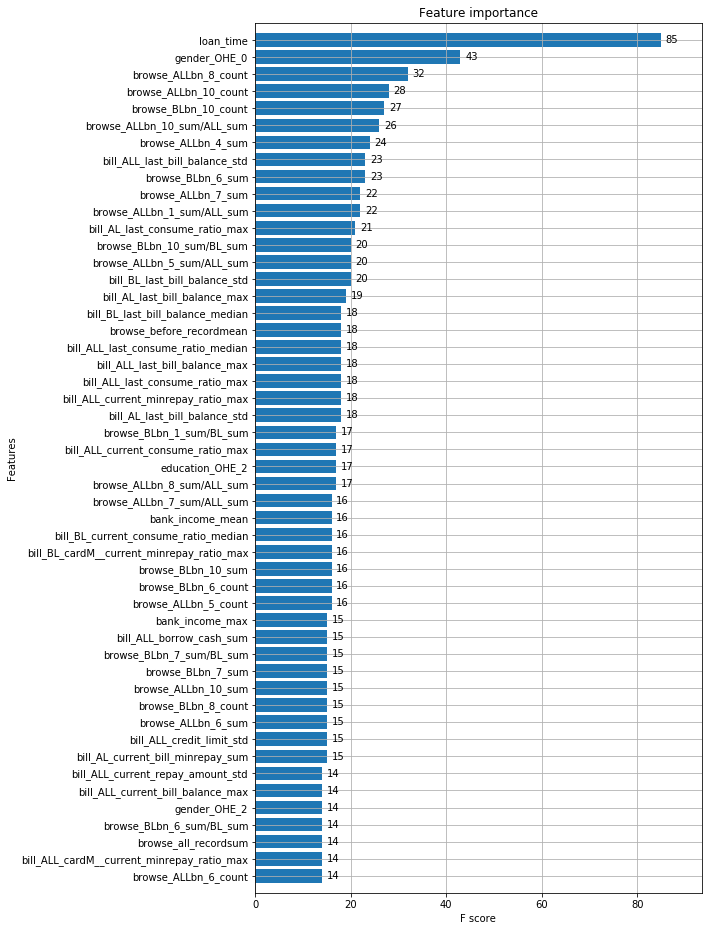

In [17]:
# 以作图形式显示 特征重要性。


fig1 = plt.figure(figsize = (8,16))
ax1 = fig1.add_subplot(111)
plot_importance(modelXGB1, ax1, height=0.8, xlim=None, ylim=None, 
                        title='Feature importance', xlabel='F score', ylabel='Features', 
                        importance_type='weight', grid=True,
                        max_num_features=50)
plt.show()
# 横轴label是 F score，这是默认的，其实就是特征重要性，每个特征出现在模型中的所有树中作为划分依赖的次数。


In [18]:
# 得到一个模型后，用模型对验证集进行概率预测，ks_statistic函数通过对比概率预测结果和验证集的真实类别结果，计算得到 K-S统计量值并返回。
# ks_statistic 函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数的返回值是 模型对此样本集的预测所计算出的 K-S统计量。K-S统计量的取值范围是0-1，模型的分类效果越好，此值越大。

# 得到一个模型后，用模型对验证集进行概率预测，ks_curve函数可以通过此预测结果画出 K-S曲线。
# ks_curve函数的参数：y_predicted_proba是对验证集里的每个样本属于正类1的概率预测， y_true是验证集里每个样本的真实类别
# （1正类，0反类）
# 此函数返回 K-S 曲线。


def ks_statistic(y_true,y_predicted_proba):
    
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    return abs(tpr-fpr).max()


def ks_curve(y_true,y_predicted_proba):
    fpr,tpr,thresholds = metrics.roc_curve(y_true,y_predicted_proba,pos_label=1)
    
    font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
    font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体
    
    fig = plt.figure(figsize = (6,8))
    ax = fig.add_subplot(111)
    ax.plot(thresholds,1.0-tpr,label="overdue",color="navy")
    ax_t = ax.twinx()
    ax_t.plot(thresholds,1.0-fpr,label="normal",color="g")
    ax.plot(thresholds,tpr-fpr,label="K-S",color="darkorange")
    ax.legend(loc=2)
    ax_t.legend(loc=9)
    ax_t.set_xlim(0.0, 1.0)
    ax_t.set_ylim(0.0, 1.0)
    ax.set_title('K-S curve',fontdict=font2 ) 
    ax.set_xlabel('threshold',fontdict=font1,labelpad= 2)  
    ax.set_ylabel('True Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_ylabel('False Positive Rate',fontdict=font1,labelpad= 6)
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 1.0)
       
    plt.show()

In [19]:
# 用 modelXGB1 对验证集X_tr_test,y_tr_test进行预测，用ks_statistic函数计算K-S统计量，值为0.46.
# Data clean 1 中进行XGBOOST特征重要性计算时，得到的ks值是 0.4478，此处比它要高一些。


y_predict_proba1 = modelXGB1.predict_proba(X_tr_test, ntree_limit=58)
ks_value1 = ks_statistic(np.array(y_tr_test),y_predict_proba1[:,1])
print("ks_value1 is: ",ks_value1)

# 注意，predict_proba会得到每个样本属于每个类别的概率。y_predict_proba是二维array，一行是一个样本，第一列是属于反类0的概率，
# 第二列是属于正类1的概率，与 model.classes_ 对应。y_predict_proba[:,1] 选出了 对每个样本属于正类1的概率的预测结果。

ks_value1 is:  0.46789436333335993


In [20]:
y_predict_proba1

array([[0.7748796 , 0.22512044],
       [0.91993386, 0.08006612],
       [0.60460806, 0.3953919 ],
       ...,
       [0.90399694, 0.09600306],
       [0.48267698, 0.517323  ],
       [0.69476736, 0.30523267]], dtype=float32)

In [21]:
modelXGB1.classes_

array([0., 1.])

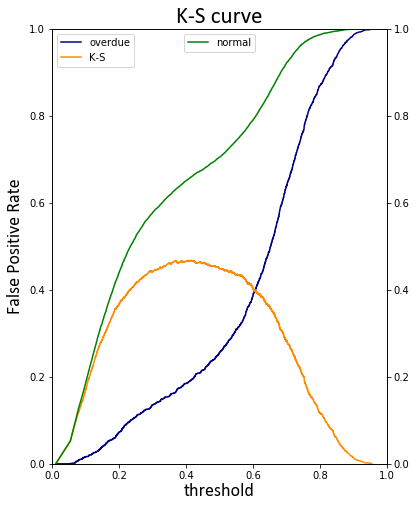

In [22]:
ks_curve(y_tr_test,y_predict_proba1[:,1])

# 2. 数据整理

1. 对所有特征的空值率进行检查，删掉空值太多且feature importance 不高的特征。
2. 剩下的特征，对空值使用算法填充。
3. 标准化。
4. 计算相关系数矩阵。
5. 对相关系数矩阵进行特征值分解，得到特征值，看特征值里0的数量，判定 做主成分分析时，保留多少主成分较好。
7. 训练LR模型。

## 2.1 特征空值率检查

In [23]:
# 对整个数据集（除去 target列，但包含了训练集+未知样本集）的各个字段特征的空值率进行统计。

colnan = CF.Calnan(data.drop(["target"],axis=1))
colnan

,column_name,nancount,nanpercent
0,gender_OHE_0,0,0.000000
1,gender_OHE_1,0,0.000000
2,gender_OHE_2,0,0.000000
3,career_OHE_0,0,0.000000
4,career_OHE_1,0,0.000000
5,career_OHE_2,0,0.000000
6,career_OHE_3,0,0.000000
7,career_OHE_4,0,0.000000
8,education_OHE_0,0,0.000000
9,education_OHE_1,0,0.000000


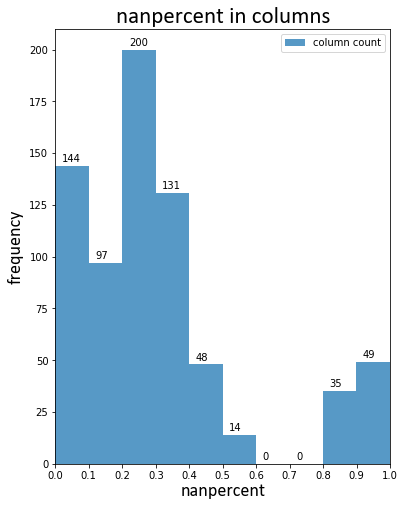

In [24]:
# 将所有字段变量的缺失率 用 直方图 的形式展示。

fig2 = plt.figure(figsize = (6,8)) # 左宽右高

font1 = {'family': 'Calibri','weight': 'normal','size': 18} # 轴标签字体
font2 = {'family': 'Calibri','weight': 'normal','size': 23} # 图标题字体

ax2 = fig2.add_subplot(111)
n2, bins2, patches2 = ax2.hist(colnan["nanpercent"], bins=10, alpha=0.75,label="column count")

ax2.set_title('nanpercent in columns',fontdict=font2 ) 
ax2.set_xlabel('nanpercent',fontdict=font1,labelpad= 2)  
ax2.set_ylabel('frequency',fontdict=font1,labelpad= 6)
# ax2.set_ylim(bottom=0 ,top =4000) 
ax2.set_xlim(left=0, right=1)   
ax2.set_xticks(np.arange(0, 1.02, step=0.1))

bin_mid2=[]
for i in range(len(bins2)-1):             # 调用 hist 作图返回的 bin2 是50个区间的共51个端点，通过这些端点可求出每个区间的中间点，存在bin_mid里。
    bin_mid2.append((bins2[i]+bins2[i+1])/2)  # 此for循环将50个区间的每个区间的中点计算出来，存储到列表 bin_mid2 中。
for x,y in zip(bin_mid2,n2):
    ax2.annotate(s=str(int(y)), xy=(x,y), xytext=(x-0.03, y+2))  # 使用annotate 添加文字标注，即每个柱子上的频数标注。
ax2.legend()
 

结论：  
&ensp;&ensp;此图展示了所有的字段变量的缺失情况。由图可知，缺失率在50%以下的变量还是占大多数，而有 14+35+49 = 98个字段变量的缺失率在50%以上。  
&ensp;&ensp;所以，只需要找出缺失率在50%以上的变量即可。

In [25]:
# 找出缺失率在50%以上的字段变量，即 colnan50 。
# 找出 colnan50里的变量的 feature importance，及其在所有变量里的特征重要性的排名。即返回的这个表。

colnan50 = colnan.loc[colnan["nanpercent"]>=0.5,"column_name"]
tmp1 = FeatureImportance.reset_index()
colnan50rank = tmp1.loc[tmp1["index"].isin(colnan50),:]
colnan50rank

,index,feature importance
2,browse_ALLbn_8_count,0.009257
26,browse_ALLbn_8_sum/ALL_sum,0.004918
30,bank_income_mean,0.004628
38,browse_BLbn_8_count,0.004339
42,bank_income_max,0.004339
61,bank_outcome_max,0.003760
66,bank_income_median,0.003471
72,browse_BLbn_3_count,0.003471
76,browse_BLbn_8_sum/BL_sum,0.003182
86,bank_outcome_mean,0.003182


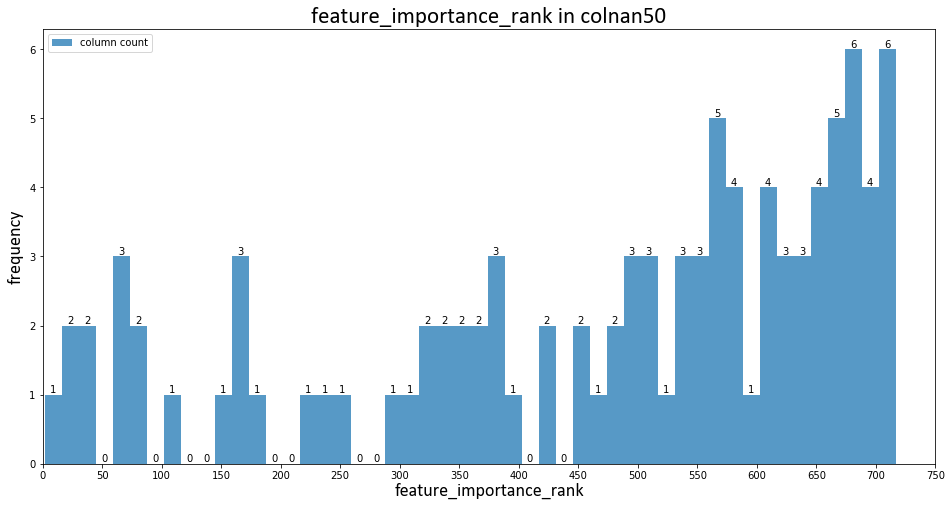

In [26]:
# 将所有具有50%及以上缺失率的字段在 XGB feature importance 里的特征重要性排序 整理出来， 用 直方图 的形式展示。

fig3 = plt.figure(figsize = (16,8)) # 左宽右高


ax3 = fig3.add_subplot(111)
n3, bins3, patches3 = ax3.hist(colnan50rank.index, bins=50, alpha=0.75,label="column count")

ax3.set_title('feature_importance_rank in colnan50',fontdict=font2 ) 
ax3.set_xlabel('feature_importance_rank',fontdict=font1,labelpad= 2)  
ax3.set_ylabel('frequency',fontdict=font1,labelpad= 6)
# ax3.set_ylim(bottom=0 ,top =4000 ) 
ax3.set_xlim(left=0, right=750)   
ax3.set_xticks(np.arange(0, 751, step=50))

bin_mid3=[]
for i in range(len(bins3)-1):             # 调用 hist 作图返回的 bin3 是50个区间的共51个端点，通过这些端点可求出每个区间的中间点，存在bin_mid里。
    bin_mid3.append((bins3[i]+bins3[i+1])/2)  # 此for循环将50个区间的每个区间的中点计算出来，存储到列表 bin_mid 中。
for x,y in zip(bin_mid3,n3):
    ax3.annotate(s=str(int(y)), xy=(x,y), xytext=(x-3, y+0.03))  # 使用annotate 添加文字标注，即每个柱子上的频数标注。

ax3.legend()
 

结论：  
&ensp;&ensp;可见，缺失率大于等于50%的所有98个字段，其在XGB特征重要性里的排名基本集中在200名以后，处于100名以上的只有10个字段。我认为，可以将100名以后的88个字段全部删掉。

In [27]:
# colnan50delete即所有的 缺失率大于等于50% 且 XGB特征重要性位于100名以后的所有特征字段，它们也是要删除的字段。

colnan50delete = colnan50rank.iloc[10:,0]

In [28]:
colnan50delete

108         bank_salaryincome_mean
146             browse_ALLbn_8_sum
161       bank_detail_record_count
162               bank_outcome_min
169           browse_ALLbn_3_count
180            browse_BLbn_9_count
223                bank_out/income
241          bank_salaryincome_max
251              browse_BLbn_8_sum
296                bank_income_min
314       bank_salaryincome_median
317          bank_salaryincome_sum
326     bank_unsalaryincome_median
332             bank_outcome_count
344              browse_BLbn_3_sum
346          bank_salaryincome_min
352        bank_unsalaryincome_sum
364       bank_unsalaryincome_mean
372        bank_unsalaryincome_min
374             browse_ALLbn_3_sum
375            browse_ALLbn_8_mean
377       browse_BLbn_3_sum/BL_sum
397                bank_income_sum
421            bank_outcome_median
426          browse_ALLbn_8_median
453       bank_salaryincome/income
456        bank_unsalaryincome_max
462             browse_ALLbn_3_max
481     browse_ALLbn

In [29]:
# 从总数据集 data 中删掉 colnan50delete 里包含的字段，得到 data_d 数据集，d 意味 delete，表示已经删掉了一些字段。

data_d = data.drop(colnan50delete,axis=1)
print("shape of data_d is ",data_d.shape)  # data_d共631个字段。631 = 719-88
data_d.head(3)

shape of data_d is  (69280, 631)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,loan_time,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5914855887,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.897688,0.8637,0.847896,0.944211,0.0,0.0,3.0,61.523250,5914855887,0.0
3,0,1,0,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18.361833,5914855887,0.0


## 2.2 算法填充空值

In [30]:
# 本函数用来依据没有缺失值的表填充有缺失值的表。
# 参数：
# df_ref 是完整的无任何缺失值的列构成的dataframe，以userID为行索引，可以作为算法填充缺失值的参考列。
# df_withnan 是所有有缺失值且需要用算法填充的列构成的dataframe，以userID为行索引，df_withnan必须与df_ref的行数相同！！
# userIDtrain和userIDtest分别是训练集的userID构成的list和未知样本集的userID构成的list。
# 返回值：
# 返回一个dataframe，是 df_ref和已填充的 df_withnan 左右concat之后得到的表，此表是完整的，没有缺失值。

# 基本思路见《SKlearn 缺失值处理方式》




def RFR_fillna(df_ref, df_withnan, userIDtrain, userIDtest):    # 用 随机森林回归算法填充缺失值。
    
    df_fillna = []  # 把 df_withnan中每个填充好的列收集到 df_fillna 里
    
    for i in df_withnan.columns :  # 对 df_withnan 里的每一列进行循环填充
        df = pd.concat([pd.DataFrame(df_withnan.loc[:,i]),df_ref],axis=1)  # 把待填充列 i 与 df_ref 左右连接得到 df，且列 i在最左侧
        
        df_train = df.loc[userIDtrain,:]
        df_test = df.loc[userIDtest,:]
        
        df_train_complete = df_train.loc[df_train[i].notnull(),:]
        df_train_incomplete = df_train.loc[df_train[i].isnull(),:]
        df_test_complete = df_test.loc[df_test[i].notnull(),:]
        df_test_incomplete = df_test.loc[df_test[i].isnull(),:]
        
               
        X_tr = df_train_complete.iloc[:,1:]  
        Y_tr = df_train_complete.iloc[:,0]
        X_te = pd.concat([df_train_incomplete.iloc[:,1:],df_test_incomplete.iloc[:,1:]])
        
        regr = RandomForestRegressor(n_estimators = 20,max_depth=10,random_state=0,n_jobs=-1) # 注意，一定设置random_state，以保证下一次的填充是一样的。
        regr.fit(X_tr,Y_tr)
        index = X_te.index
        tmp1=pd.DataFrame(regr.predict(X_te),index=index,columns=[i]) 
        
        # 将 df_complete的第 i 列和 tmp1 上下连接，得到 column_fillna，它是完整的填充好的第 i 列。
        column_fillna = pd.concat([pd.DataFrame(Y_tr),tmp1,pd.DataFrame(df_test_complete.loc[:,i])]).sort_index() 
        df_fillna.append(column_fillna)  # 将填充好的第 i 列添加到 df_fillna 里收集起来
        
    tmp = pd.concat(df_fillna,axis=1) # tmp是已经填充好缺失值的 df_withnan.
    return pd.concat([df_ref,tmp],axis = 1)  # 将 df_ref 和 tmp 左右结合，返回，即完整的没有缺失值的 整个表。
         

In [31]:
# 从 data_d 中得到user_info_OHE,loan_time这两部分，都是完全已知无缺失的，将它们合并得到df_ref1.

user_info_complete = data_d.loc[:,"gender_OHE_0":"residence_OHE_4"]
loan_time_complete = data_d.loc[:,"loan_time"]
df_ref1= pd.concat([user_info_complete,loan_time_complete],axis=1) 

In [32]:
df_ref1.head(2)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,marriage_OHE_2,marriage_OHE_3,marriage_OHE_4,marriage_OHE_5,residence_OHE_0,residence_OHE_1,residence_OHE_2,residence_OHE_3,residence_OHE_4,loan_time
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,5914855887
2,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,5914855887


In [33]:
# 从 data_d 中得到原来 bank_detail_stats 对应的 浏览信息部分，它的各个列都是数值型列且是有缺失的，待填充，为 df_withnan1.
# 可见，删掉 colnan50delete 后，data_d 里 bank_detail_stats 部分只剩下了 5 列。

df_withnan1 = data_d.loc[:,[x.startswith("bank") for x in data_d.columns]]
print("shape of df_ref1 is:",df_ref1.shape)
print("shape of df_withnan1 is:",df_withnan1.shape)
df_withnan1.head(2)

shape of df_ref1 is: (69280, 25)
shape of df_withnan1 is: (69280, 5)


,bank_income_max,bank_income_mean,bank_income_median,bank_outcome_max,bank_outcome_mean
userID,,,,,
1,17.557544,13.734079,14.855275,17.15786,13.255397
2,NaN,NaN,NaN,NaN,NaN


In [34]:
# 使用自定义函数 RFR_fillna，对 bank 部分的缺失值进行填充（训练集+未知样本集），得到完全填充的
# user_info_complete,bank_complete,loan_time_complete 左右concat构成的表 df_ref2.此表的shape为(69280, 30)，完全无缺失。

t0 = time.time()
df_ref2 = RFR_fillna(df_ref1, df_withnan1, userIDtrain, userIDtest)
t1 = time.time()
print("Time: {:.3f} seconds".format(t1-t0))

# 可以调整 随机森林 里的 max_depth，看看时间。

Time: 2.589 seconds


In [35]:
print("shape of df_ref2 is:",df_ref2.shape)
df_ref2.head(2)

shape of df_ref2 is: (69280, 30)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,residence_OHE_1,residence_OHE_2,residence_OHE_3,residence_OHE_4,loan_time,bank_income_max,bank_income_mean,bank_income_median,bank_outcome_max,bank_outcome_mean
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,5914855887,17.557544,13.734079,14.855275,17.157860,13.255397
2,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,5914855887,16.901525,12.644068,13.411078,15.762747,11.368880


In [36]:
CF.Calnan(df_ref2)["nancount"].value_counts()  # 可见，全部填充完毕，没有空值。

0    30
Name: nancount, dtype: int64

In [37]:
# 现在，用完全已知无缺失的 df_ref2（包含user_info_complete,bank_detail_complete,loan_time_complete三部分）作为 ref。
# 从 data_d中得到原来 browse_history_stats对应的 信用卡信息部分，它的各个列都是数值型列且是有缺失的，待填充，为 df_withnan2.

df_withnan2 = data_d.loc[:,[x.startswith("browse") for x in data_d.columns]]
print("shape of df_ref2 is:",df_ref2.shape)
print("shape of df_withnan2 is:",df_withnan2.shape)
df_withnan2.head(2)

shape of df_ref2 is: (69280, 30)
shape of df_withnan2 is: (69280, 103)


,browse_all_recordsum,browse_all_recordmax,browse_all_recordmean,browse_all_recordmedian,browse_all_recordmin,browse_all_recordcount,browse_all_kindcount,browse_ALLbn_1_sum,browse_ALLbn_4_sum,browse_ALLbn_5_sum,...,browse_BLbn_7_count,browse_BLbn_8_count,browse_BLbn_10_count,browse_BLbn_1_sum/BL_sum,browse_BLbn_4_sum/BL_sum,browse_BLbn_5_sum/BL_sum,browse_BLbn_6_sum/BL_sum,browse_BLbn_7_sum/BL_sum,browse_BLbn_8_sum/BL_sum,browse_BLbn_10_sum/BL_sum
userID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,151500.0,213.0,116.091954,120.0,7.0,1305.0,8.0,59820.0,22725.0,19230.0,...,105.0,105.0,75.0,0.394851,0.15,0.126931,0.031089,0.040594,0.088812,0.094059


In [38]:
# 使用自定义函数 RFR_fillna，对 browse 部分的缺失值进行填充（训练集+未知样本集），得到完全填充的
# user_info_complete,bank_complete,loan_time_complete,browse_complete 左右concat构成的表 df_ref3.
# 此表的shape为(69280, 133)，完全无缺失。

t2 = time.time()
df_ref3 = RFR_fillna(df_ref2, df_withnan2, userIDtrain, userIDtest)
t3 = time.time()
print("Time: {:.3f} seconds".format(t3-t2))

# 可以调整 随机森林 里的 max_depth，看看时间。

Time: 276.554 seconds


In [39]:
print("shape of df_ref3 is:",df_ref3.shape)
df_ref3.head(2)

shape of df_ref3 is: (69280, 133)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,browse_BLbn_7_count,browse_BLbn_8_count,browse_BLbn_10_count,browse_BLbn_1_sum/BL_sum,browse_BLbn_4_sum/BL_sum,browse_BLbn_5_sum/BL_sum,browse_BLbn_6_sum/BL_sum,browse_BLbn_7_sum/BL_sum,browse_BLbn_8_sum/BL_sum,browse_BLbn_10_sum/BL_sum
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,47.651736,29.04828,40.429438,0.514376,0.207161,0.106109,0.052207,0.048226,0.055541,0.100039
2,0,1,0,0,0,1,0,0,0,0,...,105.000000,105.00000,75.000000,0.394851,0.150000,0.126931,0.031089,0.040594,0.088812,0.094059


In [40]:
CF.Calnan(df_ref3)["nancount"].value_counts()  # 可见，全部填充完毕，没有空值。

0    133
Name: nancount, dtype: int64

In [41]:
# 现在，用完全已知无缺失的 df_ref3（包含user_info_complete,bank_detail_complete,loan_time_complete,browse_complete
# 四部分）作为 ref。
# 从 data_d中得到原来 bill_detail_stats对应的 信用卡信息部分，它的各个列都是数值型列且是有缺失的，待填充，为 df_withnan3.

df_withnan3 = data_d.loc[:,[x.startswith("bill") for x in data_d.columns]]
print("shape of df_ref3 is:",df_ref3.shape)
print("shape of df_withnan3 is:",df_withnan3.shape)
df_withnan3.head(2)

shape of df_ref3 is: (69280, 133)
shape of df_withnan3 is: (69280, 497)


,bill_all_recordcount,bill_ALL_last_bill_amount_sum,bill_ALL_last_bill_amount_max,bill_ALL_last_bill_amount_median,bill_ALL_last_bill_amount_mean,bill_ALL_last_bill_amount_min,bill_ALL_last_bill_amount_std,bill_ALL_last_repay_amount_sum,bill_ALL_last_repay_amount_max,bill_ALL_last_repay_amount_median,...,bill_AL_cardM__current_consume_ratio_median,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum
userID,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20.0,300.59944,21.580308,19.254119,15.029972,0.0,9.041778,294.503607,21.693954,18.222086,...,0.840357,0.487417,0.897688,0.8637,0.847896,0.944211,0.0,0.0,3.0,61.52325


In [42]:
# 使用自定义函数 RFR_fillna，对 bill 部分的缺失值进行填充（训练集+未知样本集），得到完全填充的
# user_info_complete,bank_complete,loan_time_complete,browse_complete,bill_complete 左右concat构成的表 df_ref4。

t4 = time.time()
df_ref4 = RFR_fillna(df_ref3, df_withnan3, userIDtrain, userIDtest)
t5 = time.time()
print("Time: {:.3f} seconds".format(t5-t4))

# 可以调整 随机森林 里的 max_depth，看看时间。

Time: 10637.272 seconds


In [43]:
print("shape of df_ref4 is:",df_ref4.shape)
df_ref4.head(2)

shape of df_ref4 is: (69280, 630)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_median,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.752572,0.385058,0.894259,0.868981,0.824092,0.841667,0.650522,0.261728,3.612082,65.795348
2,0,1,0,0,0,1,0,0,0,0,...,0.840357,0.487417,0.897688,0.863700,0.847896,0.944211,0.000000,0.000000,3.000000,61.523250


In [44]:
CF.Calnan(df_ref4)["nancount"].value_counts()  # 可见，全部填充完毕，没有空值。

0    630
Name: nancount, dtype: int64

In [45]:
# 将 df_ref4 和 target列左右 concat，得到 数据集 data_d_f，它包含训练集+未知样本集。
# d 表示之前的 delete缺失值高的特征，f表示 fillna，填充缺失值。
# 此表的shape为(69280, 631)，完全无缺失。

data_d_f = pd.concat([df_ref4,data_d["target"]],axis=1)
print("shape of data_d_f is:",data_d_f.shape)
data_d_f.head(2)

shape of data_d_f is: (69280, 631)


,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum,target
userID,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0,0,1,0,0,0,0,...,0.385058,0.894259,0.868981,0.824092,0.841667,0.650522,0.261728,3.612082,65.795348,0.0
2,0,1,0,0,0,1,0,0,0,0,...,0.487417,0.897688,0.863700,0.847896,0.944211,0.000000,0.000000,3.000000,61.523250,0.0


分离数据集。

In [46]:
# 从数据集 data_d_f中提取出训练集和未知样本集
# 训练集 data_d_f_tr，(55381, 631)。未知样本集 data_d_f_te，(13899, 631)

data_d_f_tr = data_d_f.loc[userIDtrain,:]
print("shape of data_d_f_tr is:",data_d_f_tr.shape )
data_d_f_te = data_d_f.loc[userIDtest,:]
print("shape of data_d_f_te is:",data_d_f_te.shape )

shape of data_d_f_tr is: (55381, 631)
shape of data_d_f_te is: (13899, 631)


In [47]:
# 对训练集 data_d_f_tr 进行目标变量分离，分成 字段部分 X_d_f_tr和 目标变量部分 y_d_f_tr。
# 对未知样本集 data_d_f_te 进行目标变量分离，分成 字段部分 X_d_f_te和 目标变量部分 y_d_f_te。


X_d_f_tr = data_d_f_tr.drop(["target"],axis=1)
y_d_f_tr = data_d_f_tr.loc[:,"target"]
X_d_f_te = data_d_f_te.drop(["target"],axis=1)
y_d_f_te = data_d_f_te.loc[:,"target"]
print("shape of X_d_f_tr is:",X_d_f_tr.shape)
print("shape of y_d_f_tr is:",y_d_f_tr.shape)
print("shape of X_d_f_te is:",X_d_f_te.shape)
print("shape of y_d_f_te is:",y_d_f_te.shape)

shape of X_d_f_tr is: (55381, 630)
shape of y_d_f_tr is: (55381,)
shape of X_d_f_te is: (13899, 630)
shape of y_d_f_te is: (13899,)


In [48]:
CF.Calnan(X_d_f_tr)["nancount"].value_counts()

0    630
Name: nancount, dtype: int64

## 2.3 标准化

In [49]:
data_column_names = X_d_f_tr.columns  # 保留列名

In [50]:
data_column_names 

Index(['gender_OHE_0', 'gender_OHE_1', 'gender_OHE_2', 'career_OHE_0',
       'career_OHE_1', 'career_OHE_2', 'career_OHE_3', 'career_OHE_4',
       'education_OHE_0', 'education_OHE_1',
       ...
       'bill_AL_cardM__current_consume_ratio_median',
       'bill_AL_cardM__current_consume_ratio_min',
       'bill_AL_cardM__current_minrepay_ratio_max',
       'bill_AL_cardM__current_minrepay_ratio_median',
       'bill_AL_cardM__current_minrepay_ratio_min',
       'bill_AL_cardM__borrow_cash_ratio_max',
       'bill_AL_cardM__borrow_cash_ratio_median',
       'bill_AL_cardM__borrow_cash_ratio_min', 'bill_card_count',
       'bill_credit_limit_cardsum'],
      dtype='object', length=630)

In [51]:
# 标准化 训练集的字段变量部分 X_d_f_tr 为 X_d_f_tr_std。std代表标准化standard。
# 用训练集的均值和方差标准化 未知样本集的字段变量部分 X_d_f_te 为 X_d_f_te_std。

scaler1 = StandardScaler()
scaler1.fit(X_d_f_tr)
X_d_f_tr_std = scaler1.transform(X_d_f_tr)
X_d_f_te_std = scaler1.transform(X_d_f_te)
print("shape of X_d_f_tr_std is: ",X_d_f_tr_std.shape)
print("shape of X_d_f_te_std is: ",X_d_f_te_std.shape)

shape of X_d_f_tr_std is:  (55381, 630)
shape of X_d_f_te_std is:  (13899, 630)


In [52]:
CF.Calnan(pd.DataFrame(X_d_f_tr_std))["nancount"].value_counts()

0    630
Name: nancount, dtype: int64

## 2.4 计算相关系数矩阵

In [53]:
# 训练集的字段变量部分经标准化后得到 X_d_f_tr_std，对它计算 相关系数矩阵。
# 因为一共 630 个字段变量，所以得到的也是 630*630 的方阵。

X_d_f_tr_std_correlation_matrix = covariance.empirical_covariance(X_d_f_tr_std)  
print("shape of X_d_f_tr_std_correlation_matrix is:",X_d_f_tr_std_correlation_matrix.shape)

# 注意，在手动标准化 数据集的前提下，用covariance.empirical_covariance(X_d_f_tr_std) 和 
# 用 np.corrcoef(X_d_f_tr_std,rowvar=False) 计算出来的相关系数矩阵是相同的。但是，
# 用 covariance.empirical_covariance 时没有报错，用 np.corrcoef时报错：
# RuntimeWarning: invalid value encountered in true_divide，似乎是 有发生除以 0 的情况。
# 而且，covariance.empirical_covariance算出的相关系数矩阵里没有 nan,
# 但 np.corrcoef 算出的有 nan。
# 暂时还不清楚为什么会这样。可能是版本问题？？但应该不会发生 除以 0 的情况？

shape of X_d_f_tr_std_correlation_matrix is: (630, 630)


In [54]:
X_d_f_tr_std_correlation_matrix  # 可见，对角线都是1.0.

# 另外，可以用 matplotlib 的 heatmap 以图像方式展示 相关系数矩阵，但因此处特征过多，所以放弃此方法。

array([[ 1.        , -0.34752543, -0.08080417, ...,  0.00671074,
        -0.00519137, -0.00607444],
       [-0.34752543,  1.        , -0.90652287, ..., -0.02241654,
        -0.02198425, -0.0034097 ],
       [-0.08080417, -0.90652287,  1.        , ...,  0.02080715,
         0.02570618,  0.00635929],
       ...,
       [ 0.00671074, -0.02241654,  0.02080715, ...,  1.        ,
        -0.27896334, -0.28108248],
       [-0.00519137, -0.02198425,  0.02570618, ..., -0.27896334,
         1.        ,  0.94425937],
       [-0.00607444, -0.0034097 ,  0.00635929, ..., -0.28108248,
         0.94425937,  1.        ]])

## 2.5 特征值分解/奇异值分解

In [56]:
# 相关系数方阵是 实对称方阵，一定可以对角化（即一定可以进行特征值分解），当然也可以进行奇异值分解。
# 求此相关系数方阵进行 SVD 奇异值分解。得到的 sigma 是 1*630的一维向量，里面是所有的奇异值，从大到小排列。

sigma = np.linalg.svd(X_d_f_tr_std_correlation_matrix,compute_uv=False)

In [57]:
print("len of sigma:",len(sigma))
sigma

len of sigma: 630


array([6.09663596e+01, 4.39780579e+01, 3.30510777e+01, 2.73324790e+01,
       2.52843927e+01, 2.03163990e+01, 1.76000640e+01, 1.60899949e+01,
       1.52645737e+01, 1.42677018e+01, 1.33506774e+01, 1.30897654e+01,
       1.25686103e+01, 1.00149745e+01, 9.49308687e+00, 9.43225417e+00,
       8.94498765e+00, 8.19853816e+00, 7.10105208e+00, 6.69761995e+00,
       6.52619197e+00, 6.39902271e+00, 5.93606410e+00, 5.80948570e+00,
       5.50010931e+00, 5.29209224e+00, 5.00613734e+00, 4.75345694e+00,
       4.52572344e+00, 4.29905234e+00, 4.22710958e+00, 4.11400808e+00,
       3.98745363e+00, 3.84400939e+00, 3.62381808e+00, 3.43298478e+00,
       3.30547471e+00, 3.26236901e+00, 3.25815771e+00, 3.09872656e+00,
       3.07189899e+00, 2.99428543e+00, 2.97978098e+00, 2.84136500e+00,
       2.80582823e+00, 2.71284916e+00, 2.65760494e+00, 2.57541227e+00,
       2.47105464e+00, 2.34690596e+00, 2.29314380e+00, 2.24112313e+00,
       2.15442646e+00, 2.11365568e+00, 2.07622212e+00, 1.94597455e+00,
      

In [58]:
# 求此相关系数方阵进行 特征值分解。得到的 w 是 1*630的一维向量，里面是所有的特征值，从大到小排列。
# 此相关系数方阵的奇异值分解和特征值分解结果相同（因为此相关系数矩阵是正定方阵？）。
# 因为 w的结果是复数形式，还含有j，所以直接使用奇异值分解结果即可。

w,v = np.linalg.eig(X_d_f_tr_std_correlation_matrix)

In [59]:
print("len of w:",len(w))
w

len of w: 630


array([ 6.09663596e+01+0.0000000e+00j,  4.39780579e+01+0.0000000e+00j,
        3.30510777e+01+0.0000000e+00j,  2.73324790e+01+0.0000000e+00j,
        2.52843927e+01+0.0000000e+00j,  2.03163990e+01+0.0000000e+00j,
        1.76000640e+01+0.0000000e+00j,  1.60899949e+01+0.0000000e+00j,
        1.52645737e+01+0.0000000e+00j,  1.42677018e+01+0.0000000e+00j,
        1.33506774e+01+0.0000000e+00j,  1.30897654e+01+0.0000000e+00j,
        1.25686103e+01+0.0000000e+00j,  1.00149745e+01+0.0000000e+00j,
        9.49308687e+00+0.0000000e+00j,  9.43225417e+00+0.0000000e+00j,
        8.94498765e+00+0.0000000e+00j,  8.19853816e+00+0.0000000e+00j,
        7.10105208e+00+0.0000000e+00j,  6.69761995e+00+0.0000000e+00j,
        6.52619197e+00+0.0000000e+00j,  6.39902271e+00+0.0000000e+00j,
        5.93606410e+00+0.0000000e+00j,  5.80948570e+00+0.0000000e+00j,
        5.50010931e+00+0.0000000e+00j,  5.29209224e+00+0.0000000e+00j,
        5.00613734e+00+0.0000000e+00j,  4.75345694e+00+0.0000000e+00j,
      

In [60]:
# 求此相关系数方阵的 秩。（原理上是通过 SVD）

np.linalg.matrix_rank(X_d_f_tr_std_correlation_matrix )

621

In [61]:
# 相关系数矩阵进行特征值分解后，得到若干特征值，从大到小排序，取前边多少个特征值的和，会让此和占到总特征值和的95%以上？
# 这其实是 PCA 降维的 维度选择问题。
# 本函数计算需要取多少个特征值的和，才能让此和占到总特征值和的某百分比以上。
# 两个参数：eig是某方阵进行特征值分解后所得的所有特征值（包括最后的0），percent是你想要的比例。
# 此函数返回 索引值 i ，但因为for循环在break之前先进行，所以得到的是第一个不满足(sp/s)<percent，
# 所以，其实索引值是i-1时是正好的，但是因为想要的是特征值个数，而索引从0开始，所以最终需要的是 i-1+1 = i 。
# 例如，我对数据集的相关系数矩阵进行特征值分解，得到所有特征值，我需要对前多少个特征值相加，才能够让此和在所有特征值的和里
# 占到高于95%的比例？


def eiginfoper(eig,percent):
    s = sum(eig)
    sp = 0
    for i in range(len(eig)):
        if (sp/s)<percent:
            sp+=eig[i]
        else:
            break
    return i

In [62]:
# 因为本例中，相关系数矩阵的特征值分解和奇异值分解所得的特征值和奇异值相等，
# 为了方便，使用奇异值分解。

eiginfoper(sigma,0.9)

# 可见，要达到 90% 以上，只需要 PCA 降维至 106 维就可以了。后续采用此值。

106

In [63]:
eiginfoper(sigma,0.95)

# 可见，要达到 90% 以上，需要 PCA 降维至 161 维。

161

In [64]:
eiginfoper(sigma,0.98)

# 可见，要达到 90% 以上，需要 PCA 降维至 244 维。

244

# 3. Logistic Regression

1. 使用剔除了高缺失特征，并用算法填充了缺失的新数据集：训练集X_d_f_tr，y_d_f_tr，未知样本集X_d_f_te，y_d_f_te。
2. 对训练集X_d_f_tr，y_d_f_tr进行二八分（shuffle+stratify乱序分层抽样），得到训练集：X_d_f_tr_train，y_d_f_tr_train 和 验证集X_d_f_tr_test，y_d_f_tr_test。
3. 使用训练集X_d_f_tr_train，y_d_f_tr_train训练LR模型。LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”，“PCA+白化”和“LR模型”组成管道。通过GridSearchCV进行对LR的超参数C进行交叉验证，粗选出最佳C。
4. 使用 hyperopt 选出最终的最佳C。
5. 在最佳C下，训练集 X_d_f_tr_train，y_d_f_tr_train进行学习，学得的模型对 验证集 X_d_f_tr_test，y_d_f_tr_test 进行预测。并计算auc和ks评分。
6. 在整个训练集X_d_f_tr，y_d_f_tr上进行五折交叉验证（最佳C下），得到5个 auc和ks值供参考。
7. 在最佳C下，训练集 X_d_f_tr，y_d_f_tr 训练 LR模型，得到的模型对未知样本集 X_d_f_te 进行预测，保存预测结果 LRPre.

## 3.1 数据准备

In [65]:
# 使用剔除了高缺失特征，并用算法填充了缺失的新数据集：训练集X_d_f_tr，y_d_f_tr
# 使用 train_test_split 将 X_d_f_tr，y_d_f_tr 二八划分成训练集：X_d_f_tr_train，y_d_f_tr_train 和 
# 验证集 X_d_f_tr_test，y_d_f_tr_test。
# 可见，训练集 44304 个用户，验证集 11077 个用户。
# train_test_split 默认 shuffle数据，所以不必担心。还可以设置 stratify 分层抽样。


X_d_f_tr_train, X_d_f_tr_test, y_d_f_tr_train, y_d_f_tr_test = train_test_split(X_d_f_tr,y_d_f_tr, test_size = 0.2, shuffle=True, stratify=y_d_f_tr, random_state = 1)
print("shape of X_d_f_tr_train is:",X_d_f_tr_train.shape)
print("shape of y_d_f_tr_train is:",y_d_f_tr_train.shape)
print("shape of X_d_f_tr_test is:",X_d_f_tr_test.shape)
print("shape of y_d_f_tr_test is:",y_d_f_tr_test.shape)


shape of X_d_f_tr_train is: (44304, 630)
shape of y_d_f_tr_train is: (44304,)
shape of X_d_f_tr_test is: (11077, 630)
shape of y_d_f_tr_test is: (11077,)


In [66]:
X_d_f_tr_train.head(2)

,gender_OHE_0,gender_OHE_1,gender_OHE_2,career_OHE_0,career_OHE_1,career_OHE_2,career_OHE_3,career_OHE_4,education_OHE_0,education_OHE_1,...,bill_AL_cardM__current_consume_ratio_median,bill_AL_cardM__current_consume_ratio_min,bill_AL_cardM__current_minrepay_ratio_max,bill_AL_cardM__current_minrepay_ratio_median,bill_AL_cardM__current_minrepay_ratio_min,bill_AL_cardM__borrow_cash_ratio_max,bill_AL_cardM__borrow_cash_ratio_median,bill_AL_cardM__borrow_cash_ratio_min,bill_card_count,bill_credit_limit_cardsum
userID,,,,,,,,,,,,,,,,,,,,,
36297,0,1,0,0,0,0,1,0,0,0,...,0.744941,0.425606,0.886628,0.867176,0.837027,0.787228,0.669230,0.317747,1.0,20.233635
27395,0,1,0,0,0,0,1,0,0,0,...,0.765202,0.487417,0.893888,0.867572,0.826375,0.791434,0.572316,0.339944,5.0,83.606623


## 3.2 GridSearchCV 交叉验证粗取最佳超参数

In [67]:
# LR模型只有一个超参数C。使用 pipeline，将 “标准化StandardScaler”,“PCA+白化”和“LR模型”组成管道。
# 通过GridSearchCV对训练集X_d_f_tr_train，y_d_f_tr_train进行5折交叉验证，从而实现对LR的超参数C进行
# 交叉验证，选出最佳C。

LR_parameter = {"penalty": "l2","tol": 1e-4,"class_weight": 'balanced', 
                'solver': 'liblinear','max_iter':100,'random_state':2}

# 注意，PCA的参数直接设置为 降维至 106维，一定要设置 whiten=True，即对降维后的数据进行白化（即方差转变为1）
# 所以，最开始的standard实现了数据标准化，然后pca实现降维，白化实现对pca降维后的数据再次标准化，然后，把这个标准化的数据给到LR
pipe1 = Pipeline([ ("standard", StandardScaler()) ,("pca",PCA(n_components = 106,whiten=True,random_state=3)),
                  ("LR", LogisticRegression(**LR_parameter)) ])

# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid1 = dict(LR__C=[ 0.01,0.1,1,10,100,1000,10000]) 

# 若scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
# 此处可以不设置 refit，因为 scoring里只有一个评价函数。
timestart = time.time()
grid_search1 = GridSearchCV( pipe1, param_grid=param_grid1, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search1.fit(X_d_f_tr_train,y_d_f_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.061 hours


In [68]:
# 返回最佳超参数值，可见最佳C是1000
grid_search1.best_params_  

{'LR__C': 1000}

In [69]:
pipe2 = Pipeline([ ("standard", StandardScaler()) ,("pca",PCA(n_components = 106,whiten=True,random_state=3)),
                  ("LR", LogisticRegression(**LR_parameter)) ])

# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid2 = dict(LR__C=[200,500,1000,2000]) 

# 若scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
# 此处可以不设置 refit，因为 scoring里只有一个评价函数。
timestart = time.time()
grid_search2 = GridSearchCV( pipe1, param_grid=param_grid2, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search2.fit(X_d_f_tr_train,y_d_f_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.036 hours


In [70]:
# 返回最佳超参数值，可见最佳C是200
grid_search2.best_params_  

{'LR__C': 200}

In [71]:
# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid3 = dict(LR__C=[150,200,250,300]) 

# 若scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
# 此处可以不设置 refit，因为 scoring里只有一个评价函数。
timestart = time.time()
grid_search3 = GridSearchCV( pipe1, param_grid=param_grid3, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search3.fit(X_d_f_tr_train,y_d_f_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.035 hours


In [72]:
# 返回最佳超参数值，可见最佳C是200
grid_search3.best_params_  

{'LR__C': 200}

In [73]:
# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid4 = dict(LR__C=[190,200,210]) 

# 若scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
# 此处可以不设置 refit，因为 scoring里只有一个评价函数。
timestart = time.time()
grid_search4 = GridSearchCV( pipe1, param_grid=param_grid4, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search4.fit(X_d_f_tr_train,y_d_f_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.027 hours


In [74]:
# 返回最佳超参数值，可见最佳C是190
grid_search4.best_params_  

{'LR__C': 190}

In [75]:
# 只对C这一个超参数进行网格搜索。给出C的粗范围。
param_grid5 = dict(LR__C=[160,170,180,190]) 

# 若scoring指定了多个函数，则交叉验证会算多个score。而应该依据哪个函数的返回值来选择最佳超参数？在refit里指定。
# 此处可以不设置 refit，因为 scoring里只有一个评价函数。
timestart = time.time()
grid_search5 = GridSearchCV( pipe1, param_grid=param_grid5, cv=5, scoring="roc_auc", refit="roc_auc")  
grid_search5.fit(X_d_f_tr_train,y_d_f_tr_train)
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.036 hours


In [76]:
# 返回最佳超参数值，可见最佳C是180
grid_search5.best_params_  

{'LR__C': 180}

## 3.3 对验证集进行预测并求得AUC---法1  
说明：  
&ensp;&ensp;我是这样理解的，GridSearchCV 去 fit(X_d_f_tr_train,y_d_f_tr_train)时，首先按照cv=5的要求分成五折（按照GridSearchCV的规定，是分层抽样但不随机shuffle。好在我刚开始已经手动shuffle过了。则这样实现了“shuffle+分层”的抽样方法），然后，把第一种情况（4折训练集，1折验证集）包括它们对应的目标y值传给pipe，pipe里的StandardScaler先接触到 4折训练集+1折验证集，StandardScaler会对4折训练集进行 fit+transform标准化，然后把学到的均值方差应用到1折验证集上，对其也标准化（应该不会对目标变量y进行标准化，因为，查阅StandardScaler的文档，发现它的fit方法的参数里是有y的，但不会对y进行任何处理，我认为是StandardScaler为了兼容其它方法，比如这里的pipeline，还是保留了y参数，从而有一个携带，传递的效果），然后，标准化后的4折训练集+1折验证集，以及不变的y 传递给pca，则，首先，对传递过来的训练集进行PCA降维+白化，并把参数保留下来，使用这些参数对验证集也进行降维+白化，得到降维及标准化的训练集和验证集，将它们传递给LR模型，而且此时GridSearchCV 选定尝试超参数C=0.01，LR模型进行训练，得到在C=0.01下的模型，并对验证集进行预测，对比验证集真实结果，用scoring=”roc_auc”即auc标准，算得auc值。 后续过程参见GridSearchCV原理。总之，GridSearchCV会对每个超参数组合进行5次训练，得到5个score取平均，谁的平均score最高，则谁是最佳的超参数C值。  
&ensp;&ensp;grid_search.best_params_ 返回这个最佳C。  
&ensp;&ensp;另外，因为GridSearchCV设置 refit=true，所以得到最佳C后，会在整个数据集上再尝试，这时，整个数据集X_d_f_tr_train,y_d_f_tr_train给到了StandardScaler，它直接将X_d_f_tr_train标准化，保留y_d_f_tr_trainn不变，并记录了X_d_f_tr_train的均值方差标准。然后，把标准化的X_d_f_tr_train,y_d_f_tr_train给到了pca,pca对训练集进行降维+白化，并记录参数，然后，把降维+白化处理后的训练集给到LR模型，在最佳C下对整个训练集训练出模型，这个模型存储在grid_search.best_estimator_。另外我认为，对于 GridSearchCV来说，“模型”这个概念指的是pipe，毕竟GridSearchCV的第一个参数我写的是pipe而非LR，所以，我认为这个最佳模型应该是pipe，即包含了StandardScaler,pca和LR，其中，StandardScaler和pca是对整个训练集进行fit得到的，所以我认为它里面是包含了整个训练集的参数信息。而LR是对整个pca+白化处理后的训练集在C为最佳C下训练得到的。  
&ensp;&ensp;然后，grid_search. predict_proba(X_d_f_tr_test)会用这个存储在grid_search.best_estimator_里的模型预测测试集X_d_f_tr_test，因为StandardScaler+pca白化已经存储了整个训练集的标准化降维白化信息，所以可以直接用在X_d_f_tr_test上。这样是对的。然后，把处理后的X_d_f_tr_test传递给最佳LR模型，进行预测。  
&ensp;&ensp;grid_search. score(X_d_f_tr_test,y_d_f_tr_test) 同样是用grid_search.best_estimator_里的最佳模型对X_d_f_tr_test进行标准化，预测，评分，这里用的是scoring=”roc_auc”定义的auc分值。  

In [77]:
# 返回最佳模型。是在最佳超参数 C= 190 下，对整个训练集 X_d_f_tr_train,y_d_f_tr_train 进行学习得到的模型。
grid_search5.best_estimator_  

Pipeline(memory=None,
     steps=[('standard', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=106, random_state=3,
  svd_solver='auto', tol=0.0, whiten=True)), ('LR', LogisticRegression(C=180, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=2,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [78]:
# 返回使用最佳超参数值进行五折训练时，得到的 5个score的均值，且是 refit指定的 auc指标的均值。
# 可见，最佳C时，五折训练得到的五个模型对各自验证集预测的auc得分的均值为 0.6682 。
grid_search5.best_score_  

0.6682107615239439

In [79]:
# 对验证集 X_d_f_tr_test，y_d_f_tr_test 进行属于正类别1的概率预测
grid_search5.predict_proba(X_d_f_tr_test)

array([[0.50597614, 0.49402386],
       [0.46438999, 0.53561001],
       [0.54367244, 0.45632756],
       ...,
       [0.62396048, 0.37603952],
       [0.55882426, 0.44117574],
       [0.36200154, 0.63799846]])

In [80]:
# 使用best_estimator_里的最佳模型对验证集样本进行预测并计算score。score指标使用 refit指定的auc指标。
# 可见，最佳模型对验证集预测的auc是0.666左右。
grid_search5.score(X_d_f_tr_test,y_d_f_tr_test )

0.6663548434565331

In [81]:
# 算一下 ks 评分。可见， KS评分还是很低的。

ks_value = ks_statistic(np.array(y_d_f_tr_test ),grid_search5.predict_proba(X_d_f_tr_test)[:,1])
# 注意此处，千万不要把 左侧的变量的名字定义为 ks_statistic，否则算出值后，此变量会指向一个值，而非一个函数。
# 下一次再调用 ks_statistic时就会出错。犯过这个错了已经。
print("ks_value is: ",ks_value)

ks_value is:  0.24030507690712938


## 3.4 对验证集进行预测并求得AUC---法2
进行预测。法2  
  
说明：  
&ensp;&ensp;grid_search.best_params_ 得到了最佳C。然后，将之带入到pipe中，这时，pipe里的LR模型的C就固定了，然后，pipe.fit(X_d_f_tr_train,y_d_f_tr_train )，首先，StandardScaler接触到X_d_f_tr_train，会对X_d_f_tr_test进行fit和transform，即进行标准化并记录X_d_f_tr_train的均值方差。然后，把标准化后的X_d_f_tr_train和未更改的y_d_f_tr_train给到pca+白化，然后把降维白化后的数据给到LR，则LR会在最佳C下fit此数据，得到最佳模型。    
&ensp;&ensp;pipe.predict_proba(X_d_f_tr_test)是用次最佳模型对X_d_f_tr_test进行预测，首先还是StandardScaler接触到X_d_f_tr_test，但它已经存储了X_d_f_tr_train的均值方差，所以直接应用到X_d_f_tr_test上即可，然后把标准化的X_d_f_tr_test给到pca,pca记录了降维和白化的参数，然后把X_d_f_tr_test进行相应的转换，然后给到LR模型进行预测。  
&ensp;&ensp;然后调用 roc函数计算auc。  
&ensp;&ensp;我个人认为法1和法2的predict_proba 和 auc 结果应该是相同的。事实却是是相同的。证明法1法2等效。


In [82]:
# 返回最佳超参数值，可见最佳C是180
grid_search5.best_params_  

{'LR__C': 180}

In [83]:
# 这里使用了将 C值代入 pipe，得到最终 pipe的方式。用 pipe 对测试集样本进行预测，计算auc。

pipe1.set_params(LR__C=180)  # 最佳超参数值代入pipe里
pipe1.fit(X_d_f_tr_train,y_d_f_tr_train )  # 整个训练集 X_d_f_tr_train,y_d_f_tr_train 进行学习得到的模型
pipe1.predict_proba(X_d_f_tr_test) # 可见这个结果和法 1 完全相同。

array([[0.50597614, 0.49402386],
       [0.46438999, 0.53561001],
       [0.54367244, 0.45632756],
       ...,
       [0.62396048, 0.37603952],
       [0.55882426, 0.44117574],
       [0.36200154, 0.63799846]])

In [84]:
# 可见这个结果和法 1 完全相同。
roc_auc_score(y_d_f_tr_test, pipe1.predict_proba(X_d_f_tr_test)[:,1])

0.6663548072120685

In [85]:
# 算一下 ks 评分。KS评分与法1相同，还是很低的。

ks_value2 = ks_statistic(np.array(y_d_f_tr_test),pipe1.predict_proba(X_d_f_tr_test)[:,1]) 
print("ks_statistic value is: ",ks_value2)

ks_statistic value is:  0.24030507690712938


## 3.5 查看并分析详细信息

In [86]:
pd.DataFrame(grid_search5.cv_results_)

C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\shuangjun\Anaconda3\lib\site-package

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_LR__C,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.426651,0.209149,0.668211,0.677873,160,{'LR__C': 160},4,0.65006,0.681197,0.669068,...,0.676535,0.67615,0.671525,0.676089,0.673869,0.679038,0.088810,0.002752,0.009408,0.001976
1,5.167268,0.201544,0.668211,0.677873,170,{'LR__C': 170},3,0.65006,0.681197,0.669068,...,0.676535,0.67615,0.671525,0.676089,0.673869,0.679038,0.110442,0.007741,0.009408,0.001976
2,5.035574,0.195146,0.668211,0.677873,180,{'LR__C': 180},1,0.65006,0.681197,0.669068,...,0.676535,0.67615,0.671525,0.676089,0.673869,0.679038,0.075155,0.001423,0.009408,0.001976
3,5.032774,0.193936,0.668211,0.677873,190,{'LR__C': 190},1,0.65006,0.681197,0.669068,...,0.676535,0.67615,0.671525,0.676089,0.673869,0.679038,0.080546,0.001327,0.009408,0.001976


分析：  
&ensp;&ensp;grid_search.cv_results_记录了整个GridSearchCV 交叉验证期间的详细信息，可以通过dataframe格式展示。param_LR__C一列记录了超参数C的需要尝试的值，共4个。此表每一行是一个C值下的数据。split0_test_roc_auc，split1_test_roc_auc，，，split4_test_roc_auc是在此C值下五折交叉验证求得的五个模型对各自验证集进行预测，然后计算的auc值。（同理，split0_train_roc_auc等是五个模型对各自训练集进行预测，然后计算的auc值。没错，也可以对训练集进行预测）。mean_test_roc_auc是此C值下五个模型对各自验证集进行预测计算的auc值的平均值，mean_train_roc_auc是此C值下五个模型对各自训练集进行预测计算的auc值的平均值。通过比较各个C的mean_test_roc_auc，发现最大的是C为XX时的mean_test_roc_auc，此值也会被存储在grid_search.best_score_，此值对应的C就是最佳C。  
&ensp;&ensp;这里可能取的小数精度比较小，所以各个C对应的mean_test_roc_auc和mean_train_roc_auc相同。但若精度高一些，则应是C为180时，mean_test_score值最大。

## 3.6 hyperopt 求取最佳超参数

&ensp;&ensp;GridSearchCV只是求出了超参数C的大致范围，即170到190之间。我们把C的范围限制在这里，通过hyperopt在这个参数范围内寻找最佳C值。首先，使用训练LR时使用的二八分数据：训练集X_d_f_tr_train，y_d_f_tr_train 和 验证集 X_d_f_tr_test，y_d_f_tr_test。按照hyperopt的用法，需要自定义一个函数，给出超参数范围，hyperopt在这个范围内选择值，然后代入这个函数，求得函数值，使函数值最小的那个就是最佳超参数。我们这样定义函数LRfunction：对训练集X_d_f_tr_train，y_d_f_tr_train进行五折划分，在某C下，分别学得5个模型，用模型对各自的验证集预测并求auc，求得5个auc值的均值的负数，作为函数返回值，可见，此值越小，说明 auc均值越大，说明这个C固定值越佳。

In [87]:
# 使用剔除了高缺失特征，并用算法填充了缺失的新数据集：训练集X_d_f_tr，y_d_f_tr
# 使用 train_test_split 将 X_d_f_tr，y_d_f_tr 二八划分成训练集：X_d_f_tr_train，y_d_f_tr_train 和 
# 验证集 X_d_f_tr_test，y_d_f_tr_test。
# 可见，训练集 44304 个用户，验证集 11077 个用户。
# train_test_split 默认 shuffle数据，所以不必担心。还可以设置 stratify 分层抽样。

print("shape of X_d_f_tr_train is:",X_d_f_tr_train.shape)
print("shape of y_d_f_tr_train is:",y_d_f_tr_train.shape)
print("shape of X_d_f_tr_test is:",X_d_f_tr_test.shape)
print("shape of y_d_f_tr_test is:",y_d_f_tr_test.shape)

shape of X_d_f_tr_train is: (44304, 630)
shape of y_d_f_tr_train is: (44304,)
shape of X_d_f_tr_test is: (11077, 630)
shape of y_d_f_tr_test is: (11077,)


In [88]:
# 然后，对训练集X_d_f_tr_train，y_d_f_tr_train进行一次性五折划分。
# Xt 存储了 5个二维array，分别是5份训练集。  
# Xv 存储了 5个二维array，分别是对应的5份验证集。
# Yt 存储了 5个一维array，分别是对应的5份训练集的标签。
# Yv 存储了 5个一维array，分别是对应的5份验证集的标签。


skf = StratifiedKFold (n_splits=5,shuffle=True,random_state=4)  
# 保证了即shuffle又分层。（其实二八分时已经shuffle过了，此处可以不shuffle，也可以再shuffle一次）
Xt = []
Yt = []
Xv = []
Yv = []
for train_index, validation_index in skf.split(X_d_f_tr_train.values,y_d_f_tr_train.values):  
    Xt.append(X_d_f_tr_train.values[train_index])
    Yt.append(y_d_f_tr_train.values[train_index])
    Xv.append(X_d_f_tr_train.values[validation_index])
    Yv.append(y_d_f_tr_train.values[validation_index])

In [89]:
Xt

[array([[  0.        ,   1.        ,   0.        , ...,   0.33994428,
           5.        ,  83.606623  ],
        [  0.        ,   1.        ,   0.        , ...,   0.38673031,
           2.        ,  40.635689  ],
        [  0.        ,   0.        ,   1.        , ...,   0.44212774,
           1.        ,   0.        ],
        ...,
        [  0.        ,   1.        ,   0.        , ...,   0.96645698,
           4.        ,  61.636579  ],
        [  0.        ,   1.        ,   0.        , ...,   0.4543664 ,
          10.        , 169.310582  ],
        [  0.        ,   0.        ,   1.        , ...,   0.31551816,
           1.        ,   0.        ]]),
 array([[  0.        ,   1.        ,   0.        , ...,   0.31774651,
           1.        ,  20.233635  ],
        [  0.        ,   1.        ,   0.        , ...,   0.33994428,
           5.        ,  83.606623  ],
        [  0.        ,   1.        ,   0.        , ...,   0.38673031,
           2.        ,  40.635689  ],
        ...,


In [90]:
Yt

[array([0., 0., 0., ..., 0., 1., 0.]),
 array([0., 0., 0., ..., 1., 1., 0.]),
 array([0., 0., 0., ..., 0., 1., 1.]),
 array([0., 0., 0., ..., 1., 1., 0.]),
 array([0., 0., 0., ..., 1., 1., 0.])]

In [91]:
# 此段代码用 hyperopt 加 交叉验证 选择 LR 模型的最优超参数。
#（5折交叉验证）将此训练集一次性随机分成5份，以其中4份作为训练集，1份作为验证集。给模型代入一组固定的超参数值，然后，
# 用此模型对这4份训练集进行学习，用学得的模型对那1份验证集进行预测，然后，对比验证集的预测值和真实值（用Score函数，计算AUC值），
# 得到score。因为是5折，所以可以学得5个模型，进行5次相应预测，得到5个score值（这5个模型用的都是同一组超参数值），
# 求这5个score的平均值的负值，即 -np.mean(score)。将这个过程构成函数 LRfunction，这个-np.mean(score)就是LRfunction的返回值，
# 是hyperopt的评价依据。然后，定义超参数空间space，设置搜索算法algo参数，然后，使用fmin方法在超参数空间中选择能使 -np.mean(score)
# 值最小的那组超参数值。这样，就得到了最佳超参数值。
# 此处，LR 模型 只用 hyperopt 加 交叉验证 选择 "C" 这一个超参数的最优值。
# 另外，还使用了 trials 捕捉了在每一次尝试中使用的 C值 和 对应得到 的-np.mean(score)值（即loss列）


LR_parameter_space ={'C':hp.loguniform("C", 5.135, 5.247)}  
# 
# 对 LR 模型来说，只对 C 这一个超参数调参。我本来用的是 hp.loguniform("C", 5.135, 5.247)，
# 这个根据粗选结果来设定。exp(5.139)=170, exp(5.247)=190,  exp(5.193)=180 
# [exp(5.139),exp(5.247)]间的log分布。这个分布对 170到180之间的数值
# 尝试的比较多，而对 180到 190之间的尝试的较。如果介意的话可以使用均匀分布：hp.uniform('C', 170, 190)


def LRfunction(args):
    # args是LR_parameter_space
    LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                    'random_state':5,'max_iter':100,'tol':0.005} 
                    # 这个随机数是因为liblinear使用了随机过程。另外max_iter需要增加么？
    LR_parameter.update(args)
    clf = LogisticRegression(**LR_parameter)
   
    score = []
    for i in range(len(Xt)):
        # 标准化数据集
        scaler = StandardScaler()
        scaler.fit(Xt[i])
        Xti_std = scaler.transform(Xt[i])  # std表示标准化过
        Xvi_std = scaler.transform(Xv[i])
        # 降维+白化
        pca = PCA(n_components = 106,whiten=True,random_state=4)
        pca.fit(Xti_std)
        Xti_std_pca = pca.transform(Xti_std)
        Xvi_std_pca = pca.transform(Xvi_std)
        # 训练模型
        clf.fit(Xti_std_pca,Yt[i])
        # 若此时 print('LR_classes:',clf.classes_) ， 结果为：array([0, 1], dtype=int64)，即类别 0 先，类别 1 后。
        # 预测验证集
        proba_prediction = clf.predict_proba(Xvi_std_pca)
        # 所得到的 proba_prediction 是一个 二维 array，第一列是预测每个样属于第 0 类的概率，
        # 第二列是每个样属于第1类的概率。(与clf.classes_ 顺序保持一致)
        
        score.append(roc_auc_score(Yv[i],proba_prediction[:,1]))  
        # 所以这里是 proba_prediction[:,1] 取第二列。
  
    return -np.mean(score)

In [92]:
timestart = time.time()
LRtrials = Trials()
LRbest = fmin(fn = LRfunction, space = LR_parameter_space, algo=tpe.suggest, max_evals=30,trials=LRtrials)  # max_evals表示尝试30个C值，从中找最好的。可以先设为2，尝试一下。
print("Time: {:.3f} hours".format((time.time() - timestart)/3600))

Time: 0.209 hours


In [93]:
# 这里记录了 hyperopt 在循环计算时的详细情况。因为 fmin中max_evals=30，也就是要从给出的C的范围（space参数）里选出30个C值进行试验。
# LRtrials.trials 是一个 list，里面有三个字典，即尝试 30 个C值时的详细情况。
# 每个字典里，misc是一个复合字典，里面的 vals 记录了尝试的 C值。

LRtrials.trials

[{'book_time': datetime.datetime(2019, 5, 6, 0, 26, 21, 41000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [0]},
   'tid': 0,
   'vals': {'C': [188.5800176619015]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 6, 0, 26, 46, 269000),
  'result': {'loss': -0.6681510743087614, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 0,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 6, 0, 26, 46, 270000),
  'exp_key': None,
  'misc': {'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'idxs': {'C': [1]},
   'tid': 1,
   'vals': {'C': [174.4709604207803]},
   'workdir': None},
  'owner': None,
  'refresh_time': datetime.datetime(2019, 5, 6, 0, 27, 11, 497000),
  'result': {'loss': -0.6681510743087614, 'status': 'ok'},
  'spec': None,
  'state': 2,
  'tid': 1,
  'version': 0},
 {'book_time': datetime.datetime(2019, 5, 6, 0, 27, 11, 499000),
  'exp_key': None,
  'misc': {'cmd': ('domain_atta

In [94]:
# LRtrials.losses() 为一个 list，里面有30个值，分别是尝试每个C值时，LRfunction 的返回值，即 5折交叉验证求得的5个score的均值的负数。
# 我觉得应该是精度问题，实际上这些loss值是不一样的。

LRtrials.losses()

[-0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614,
 -0.6681510743087614]

In [95]:
# 将结果组成 dataframe 表 LRop。
# 第一列为 尝试的 C值，第二列是 将此C代入 LRfunction 后求出的 平均auc 值。此值越大，说明此 C 越佳。（已按auc_mean从大到小排序）
# 使得 平均auc值最大的那个 C，就是 hyperopt 选出的最佳 C。即为首行 C 。

LRop = pd.concat([pd.DataFrame([sum(list(LRtrials.trials[j]["misc"]["vals"].values()), []) for j in range(len(LRtrials))],
                                 columns = list(LRtrials.trials[0]["misc"]["vals"].keys())),
           pd.DataFrame({"auc_mean":[np.abs(i) for i in LRtrials.losses()]})], axis = 1).sort_values(by=["auc_mean"],ascending=False)

In [96]:
# 我觉得应该是精度问题，实际上这些loss值是不一样的。

LRop

,C,auc_mean
0,188.580018,0.668151
1,174.470960,0.668151
28,184.420434,0.668151
27,181.513746,0.668151
26,172.377678,0.668151
25,184.668526,0.668151
24,182.075311,0.668151
23,170.733274,0.668151
22,184.999221,0.668151
21,181.050414,0.668151


In [97]:
# 现在我们已经确定出了最佳的C值：189。然后在最佳C下对整个训练集 X_d_f_tr_train，y_d_f_tr_train进行学习，
# 学得的模型对 验证集 X_d_f_tr_test，y_d_f_tr_test 进行预测。
# 可见，对验证集进行预测算auc，值为 0.66，并不高。ks 评分为0.24，也不高。

args = {"C":189}
LR_parameter = {"penalty": "l2", "class_weight": 'balanced', 'solver': 'liblinear',
                'random_state':5,'max_iter':100,'tol':0.005} 
LR_parameter.update(args)


# 标准化数据
scaler2 = StandardScaler()
scaler2.fit(X_d_f_tr_train)
X_d_f_tr_train_std = scaler2.transform(X_d_f_tr_train)  # std表示标准化过
X_d_f_tr_test_std = scaler2.transform(X_d_f_tr_test)
        
# PCA降维+白化
pca1 = PCA(n_components = 106,whiten=True,random_state=5)
pca1.fit(X_d_f_tr_train_std)
X_d_f_tr_train_pca = pca1.transform(X_d_f_tr_train_std)
X_d_f_tr_test_pca = pca1.transform(X_d_f_tr_test_std)

# 训练模型
modelLR1 = LogisticRegression(**LR_parameter)
modelLR1.fit(X_d_f_tr_train_pca, y_d_f_tr_train)
proba_prediction1 = modelLR1.predict_proba(X_d_f_tr_test_pca)

# 计算AUC
roc_auc_score(y_d_f_tr_test, proba_prediction1[:,1])

0.6643243560627203

In [98]:
 # 算一下KS评分。
ks_statistic(np.array(y_d_f_tr_test), proba_prediction1[:,1]) 

0.24371307142116727

## 3.7 交叉验证
&ensp;&ensp;以上过程是建立在一次性二八分，用八份去通过GridSearchCV+hyperopt得到最佳C，然后在此C下对这八份进行学习得到最佳模型，然后用最佳模型对那二份进行预测并计算AUC和KS。  
&ensp;&ensp;一次性二八分会否太单一？我认为可以在此C下使用交叉验证，多算几个验证分数。也就是把整个训练集X_d_f_tr,y_d_f_tr进行五折划分，在此C下学得5个模型，这5个模型对各自的验证集进行预测，得到5个auc和ks评分。可以看看这5个评分，算一下均分。

In [99]:
# 使用去除了重度缺失的特征和填充了缺失后的数据集 data_d_f_tr, data_d_f_te。
# 对训练集 data_d_f_tr 进行目标变量分离，分成 字段部分 X_d_f_tr和 目标变量部分 y_d_f_tr。
# 对未知样本集 data_d_f_te 进行目标变量分离，分成 字段部分 X_d_f_te和 目标变量部分 y_d_f_te。

print("shape of X_d_f_tr is:",X_d_f_tr.shape)
print("shape of y_d_f_tr is:",y_d_f_tr.shape)
print("shape of X_d_f_te is:",X_d_f_te.shape)
print("shape of y_d_f_te is:",y_d_f_te.shape)

shape of X_d_f_tr is: (55381, 630)
shape of y_d_f_tr is: (55381,)
shape of X_d_f_te is: (13899, 630)
shape of y_d_f_te is: (13899,)


In [100]:
# 使用 cross_val_score 进行交叉验证
# 交叉验证显示，在最佳C下，训练的LR模型所得的auc评分也还在 0.66 左右，比较低。
# 比 Data clean 1 得到的还是要高的。说明比 Data clean 1 要好一些。

pipe2 = make_pipeline(StandardScaler(), PCA(n_components = 106,whiten=True,random_state=6),
                      LogisticRegression(**LR_parameter))  # LR_parameter 是固定参数+最佳超参数 C
scores = cross_val_score(pipe2, X_d_f_tr, y_d_f_tr,cv = 5, scoring="roc_auc")  # 或试试cv=10
print("5Fold scores :", scores)
print("5Fold mean score :", np.mean(scores))

5Fold scores : [0.67161406 0.68763762 0.66675197 0.6446581  0.63655981]
5Fold mean score : 0.6614443120125404


##  3.8 训练最终LR模型并预测未知样本集

In [101]:
# 使用去除了重度缺失的特征和填充了缺失后的数据集 data_d_f_tr, data_d_f_te。
# 对训练集 data_d_f_tr 进行目标变量分离，分成 字段部分 X_d_f_tr和 目标变量部分 y_d_f_tr。
# 对未知样本集 data_d_f_te 进行目标变量分离，分成 字段部分 X_d_f_te和 目标变量部分 y_d_f_te。

print("shape of X_d_f_tr is:",X_d_f_tr.shape)
print("shape of y_d_f_tr is:",y_d_f_tr.shape)
print("shape of X_d_f_te is:",X_d_f_te.shape)
print("shape of y_d_f_te is:",y_d_f_te.shape)

shape of X_d_f_tr is: (55381, 630)
shape of y_d_f_tr is: (55381,)
shape of X_d_f_te is: (13899, 630)
shape of y_d_f_te is: (13899,)


In [102]:
# 标准化数据
scaler3 = StandardScaler()
scaler3.fit(X_d_f_tr)
X_d_f_tr_std = scaler3.transform(X_d_f_tr)  # std表示标准化过
X_d_f_te_std = scaler3.transform(X_d_f_te)
        
# PCA降维+白化
pca2 = PCA(n_components = 106,whiten=True,random_state=5)
pca2.fit(X_d_f_tr_std)
X_d_f_tr_std_pca = pca2.transform(X_d_f_tr_std)
X_d_f_te_std_pca = pca2.transform(X_d_f_te_std)

# 训练模型
modelLR2 = LogisticRegression(**LR_parameter) # LR_parameter 是固定参数+最佳超参数 C
modelLR2.fit(X_d_f_tr_std_pca, y_d_f_tr)

# 预测未知样本集
proba_prediction2 = modelLR2.predict_proba(X_d_f_te_std_pca)

In [103]:
# 将预测结果整合成表

LRpre = pd.DataFrame(proba_prediction2[:,1],index=X_te.index,columns=["positive_proba"]).reset_index()
LRpre.columns = ["userid","probability"]  # 按官网提交示例修改列名

In [104]:
LRpre

,userid,probability
0,55597,0.577381
1,55598,0.247895
2,55599,0.244395
3,55600,0.351752
4,55601,0.509902
5,55602,0.358536
6,55603,0.498492
7,55604,0.575011
8,55605,0.401365
9,55606,0.585561


In [105]:
# 保存预测结果

LRpre.to_csv(r'F:\RiskPre2\result\Data Clean 2\LRpre.csv',index=False)

In [106]:
# 保存模型

joblib.dump(modelLR2, r'F:\RiskPre2\result\Data Clean 2\modelLR2.pkl')

['F:\\RiskPre2\\result\\Data Clean 2\\modelLR2.pkl']

# 4. 提交结果

In [107]:
# 提交 LRpre 结果：计算的 ks 值是： 0.19***5 ，很低，比之前提交的 3 次还低。比 Data clean 1 的 0.21还要低。